In [1]:
import numpy as np
from numpy import cos, sin, abs, angle

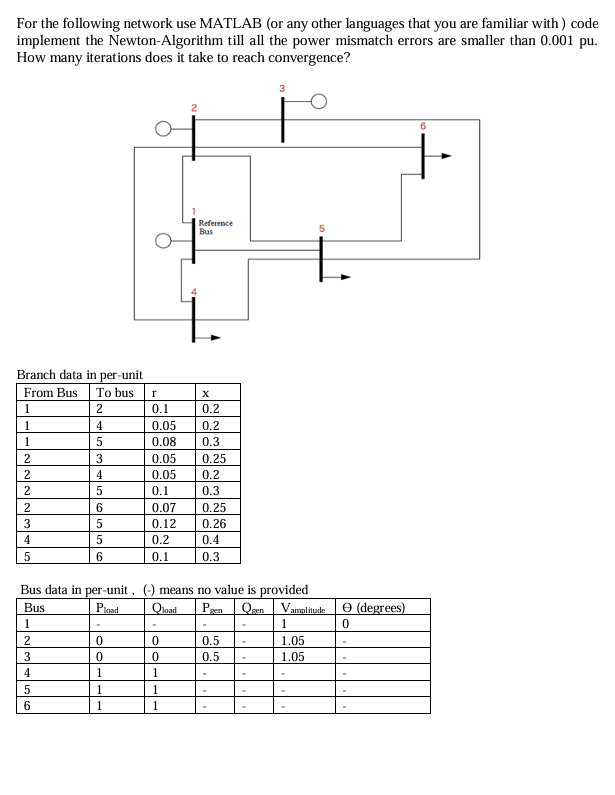

In [2]:
class Std_NR():
    """
    The code is made by 11910232 Yashvardhan Singh Raghuwanshi for HW 2, EE_521 course at WSU
    Code uses the non-linear programming (NLP) formulation to solve simple load flow using Newton Raphson
    For any doubts please reach at y.raghuwanshi@wsu.edu
    """

    def __init__(self, max_iter=100, tolerance=0.001):
        self.max_iter = max_iter;
        self.tolerance = tolerance;
        
    ###### In this code, the student has tried to reduce the number of global variables in the class and parssed everything.
    def create_ybus(self, branch_data, num_buses): ## Writing Y bus code as easily as possible
        y_bus = np.zeros((num_buses, num_buses), dtype=complex)
        for branch in branch_data:
            from_bus, to_bus, r, x = branch
            y = 1 / complex(r, x)
            y_bus[from_bus-1, to_bus-1] -= y
            y_bus[to_bus-1, from_bus-1] -= y
            y_bus[from_bus-1, from_bus-1] += y
            y_bus[to_bus-1, to_bus-1] += y
        return y_bus

    def power_mismatch(self, V, Y, P_spec, Q_spec):
        S = V * np.conj(np.dot(Y, V))
        P = S.real
        Q = S.imag
        dP = P_spec - P
        dQ = Q_spec - Q
        return np.concatenate([dP[1:], dQ[1:]]), P, Q
    
    def jacobian(self, V, Y, P, Q):
        n = len(V)
        J = np.zeros((2*(n-1), 2*(n-1)))
        
        theta = angle(V)
        V_abs = abs(V)
        ##### To avoid the Jacobian filling delima as faced in HW assignment 1, here the student is filling Jacobian directly
        for i in range(1, n):
            for k in range(1, n):
                if i == k:
                    J[i-1, k-1] = -Q[i] - V_abs[i]**2 * Y[i,i].imag
                    J[i-1, k+n-2] = P[i] / V_abs[i] + V_abs[i] * Y[i,i].real
                    J[i+n-2, k-1] = P[i] - V_abs[i]**2 * Y[i,i].real
                    J[i+n-2, k+n-2] = Q[i] / V_abs[i] - V_abs[i] * Y[i,i].imag
                else:
                    J[i-1, k-1] = V_abs[i] * V_abs[k] * (Y[i,k].real * sin(theta[i] - theta[k]) - Y[i,k].imag * cos(theta[i] - theta[k]))
                    J[i-1, k+n-2] = V_abs[i] * (Y[i,k].real * cos(theta[i] - theta[k]) + Y[i,k].imag * sin(theta[i] - theta[k]))
                    J[i+n-2, k-1] = -V_abs[i] * V_abs[k] * (Y[i,k].real * cos(theta[i] - theta[k]) + Y[i,k].imag * sin(theta[i] - theta[k]))
                    J[i+n-2, k+n-2] = V_abs[i] * (Y[i,k].real * sin(theta[i] - theta[k]) - Y[i,k].imag * cos(theta[i] - theta[k]))
        
        return J
    
    def newton_raphson(self, Y, V_init, P_spec, Q_spec):
        V = V_init.copy()
        iterations = 0
        
        while iterations < self.max_iter:
            mismatch, P, Q = self.power_mismatch(V, Y, P_spec, Q_spec)
            if np.all(abs(mismatch) < self.tolerance):
                break
            
            J = self.jacobian(V, Y, P, Q)
            dV = np.linalg.solve(J, mismatch)
            
            dtheta = dV[:len(V)-1]
            dV_abs = dV[len(V)-1:]
            
            V[1:] *= np.exp(1j * dtheta)
            V_abs = abs(V)
            V_abs[1:] += dV_abs
            V = V_abs * np.exp(1j * angle(V))
            
            iterations += 1
            
    
        return V, iterations


In [3]:
# Line data
branch_data = [
    (1, 2, 0.1, 0.2),
    (1, 4, 0.05, 0.2),
    (1, 5, 0.08, 0.3),
    (2, 3, 0.05, 0.25),
    (2, 4, 0.05, 0.2),
    (2, 5, 0.1, 0.3),
    (2, 6, 0.07, 0.25),
    (3, 5, 0.12, 0.26),
    (4, 5, 0.2, 0.4),
    (5, 6, 0.1, 0.3)
]

num_buses = 6 # manually entering the number of buses for the system however, it can be automated as well.


# Initializing the voltages manually but it can be easily automate as well
V_init = np.ones(num_buses, dtype=complex)
V_init[2] = 1.05
V_init[3] = 1.05

# Specified P and Q for \del P and \del Q calculations and avoiding load data matrix.
P_spec = np.array([0, 0, 0, 1, 1, 1])
Q_spec = np.array([0, 0.5, 0.5, 0, 0, 0])



In [4]:
NR = Std_NR(max_iter=100, tolerance=1e-6)

# Y-bus creation:
Y = NR.create_ybus(branch_data, num_buses)

# Main function call
V_final, iterations = NR.newton_raphson(Y, V_init, P_spec, Q_spec)

print(f"Convergence reached in {iterations} iterations.")
print("Final bus voltages:")
for i, v in enumerate(V_final):
    print(f"Bus {i+1}: {abs(v):.4f} < {angle(v)*180/np.pi:.2f}°")

Convergence reached in 4 iterations.
Final bus voltages:
Bus 1: 1.0000 < 0.00°
Bus 2: 1.1239 < 9.14°
Bus 3: 1.1730 < 9.74°
Bus 4: 1.0830 < 10.41°
Bus 5: 1.1202 < 12.36°
Bus 6: 1.1508 < 16.66°
